In [1]:
from google.colab import files
uploaded = files.upload()

Saving marketplace_transactions.csv to marketplace_transactions.csv


Dataset Shape: (17049, 18)
Date Range: 2023-01-01 00:00:00 to 2024-03-25 00:00:00

Missing Values:
 Order_ID                    0
Customer_ID                 0
Date                        0
Age                         0
Gender                      0
City                        0
Product_Category            0
Unit_Price                  0
Quantity                    0
Discount_Amount             0
Total_Amount                0
Payment_Method              0
Device_Type                 0
Session_Duration_Minutes    0
Pages_Viewed                0
Is_Returning_Customer       0
Delivery_Time_Days          0
Customer_Rating             0
dtype: int64

First few rows:
        Order_ID Customer_ID       Date  Age Gender      City Product_Category  \
0  ORD_000001-1  CUST_00001 2023-05-29   40   Male    Ankara            Books   
1  ORD_000001-2  CUST_00001 2023-10-12   40   Male    Ankara    Home & Garden   
2  ORD_000001-3  CUST_00001 2023-12-05   40   Male    Ankara           Sports   
3  OR

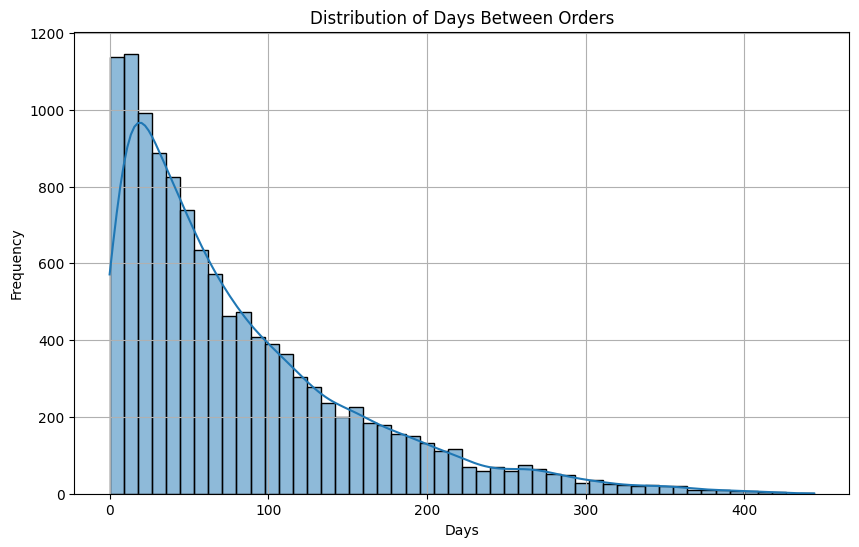


Inter-purchase Time Statistics:
 count    12049.000000
mean        81.239439
std         75.746258
min          0.000000
25%         24.000000
50%         58.000000
75%        116.000000
90%        189.000000
95%        241.000000
max        444.000000
Name: days_diff, dtype: float64


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('marketplace_transactions.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Basic Info
print("Dataset Shape:", df.shape)
print("Date Range:", df['Date'].min(), "to", df['Date'].max())
print("\nMissing Values:\n", df.isnull().sum())
print("\nFirst few rows:\n", df.head())

# Check number of unique customers
print("\nUnique Customers:", df['Customer_ID'].nunique())

# Analyze inter-purchase time to help define churn
# Sort by customer and date
df_sorted = df.sort_values(['Customer_ID', 'Date'])
# Calculate time difference between consecutive orders for each customer
df_sorted['prev_order_date'] = df_sorted.groupby('Customer_ID')['Date'].shift(1)
df_sorted['days_diff'] = (df_sorted['Date'] - df_sorted['prev_order_date']).dt.days

# Plot distribution of days between orders
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted['days_diff'].dropna(), bins=50, kde=True)
plt.title('Distribution of Days Between Orders')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate percentiles for inter-purchase time
print("\nInter-purchase Time Statistics:\n", df_sorted['days_diff'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]))

In [3]:
# Define Cutoff Date
cutoff_date = pd.Timestamp('2023-12-25')

# Split Data
history_data = df[df['Date'] <= cutoff_date].copy()
future_data = df[df['Date'] > cutoff_date].copy()

print(f"History Data: {history_data['Date'].min()} to {history_data['Date'].max()}")
print(f"Future Data: {future_data['Date'].min()} to {future_data['Date'].max()}")

# Base Population: Customers who existed in history
base_customers = history_data['Customer_ID'].unique()
print(f"Base Customer Population: {len(base_customers)}")

# --- Feature Engineering ---

# 1. Aggregations
# Group by CustomerID
# We need to handle categorical modes carefully.
def get_mode(x):
    return x.mode().iloc[0] if not x.mode().empty else None

# Aggregate functions
agg_funcs = {
    'Date': 'max', # For Recency
    'Order_ID': 'nunique', # Frequency
    'Total_Amount': 'sum', # Monetary
    'Session_Duration_Minutes': 'mean',
    'Pages_Viewed': 'mean',
    'Customer_Rating': 'mean',
    'Delivery_Time_Days': 'mean',
    'Discount_Amount': 'mean',
    'Age': 'max',
    'Gender': 'first',
    'City': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0], # Mode or first
    'Device_Type': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    'Product_Category': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0],
    'Payment_Method': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
}

# Apply aggregations
customer_features = history_data.groupby('Customer_ID').agg(agg_funcs).reset_index()

# Rename columns for clarity
customer_features.rename(columns={
    'Date': 'Last_Purchase_Date',
    'Order_ID': 'Frequency',
    'Total_Amount': 'Monetary',
    'Session_Duration_Minutes': 'Avg_Session_Duration',
    'Pages_Viewed': 'Avg_Pages_Viewed',
    'Customer_Rating': 'Avg_Rating',
    'Delivery_Time_Days': 'Avg_Delivery_Time',
    'Discount_Amount': 'Avg_Discount',
    'Product_Category': 'Fav_Category',
    'Payment_Method': 'Fav_Payment',
    'Device_Type': 'Fav_Device'
}, inplace=True)

# Calculate Recency
customer_features['Recency'] = (cutoff_date - customer_features['Last_Purchase_Date']).dt.days

# Drop the date column now
customer_features.drop('Last_Purchase_Date', axis=1, inplace=True)

# Additional Feature: Avg Spend per Order
customer_features['Avg_Spend'] = customer_features['Monetary'] / customer_features['Frequency']

# --- Target Creation ---
# Customers who bought in future
active_in_future = future_data['Customer_ID'].unique()

# Create Churn Label: 1 if NOT in active_in_future, 0 otherwise
customer_features['Churn'] = customer_features['Customer_ID'].apply(lambda x: 0 if x in active_in_future else 1)

print("\nClass Distribution:")
print(customer_features['Churn'].value_counts(normalize=True))

# Check Data
print(customer_features.head())
print(customer_features.info())

History Data: 2023-01-01 00:00:00 to 2023-12-25 00:00:00
Future Data: 2023-12-26 00:00:00 to 2024-03-25 00:00:00
Base Customer Population: 4750

Class Distribution:
Churn
1    0.536421
0    0.463579
Name: proportion, dtype: float64
  Customer_ID  Frequency  Monetary  Avg_Session_Duration  Avg_Pages_Viewed  \
0  CUST_00001          3   2199.63             14.333333          9.000000   
1  CUST_00002          2    809.90             15.000000         10.000000   
2  CUST_00003          1    396.56             10.000000          9.000000   
3  CUST_00005          3   2422.73             12.666667          9.333333   
4  CUST_00006          3   1245.83             16.000000          9.333333   

   Avg_Rating  Avg_Delivery_Time  Avg_Discount  Age  Gender      City  \
0    3.333333           9.333333     46.016667   40    Male    Ankara   
1    4.000000           5.000000     35.525000   33    Male  Istanbul   
2    2.000000           6.000000      0.000000   42    Male     Konya   
3    3.

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score

# 1. Define Features and Target
X = customer_features.drop(['Customer_ID', 'Churn'], axis=1)
y = customer_features['Churn']

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Preprocessing Pipeline
numeric_features = ['Frequency', 'Monetary', 'Avg_Session_Duration', 'Avg_Pages_Viewed',
                    'Avg_Rating', 'Avg_Delivery_Time', 'Avg_Discount', 'Age', 'Recency', 'Avg_Spend']
categorical_features = ['Gender', 'City', 'Fav_Device', 'Fav_Category', 'Fav_Payment']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Model 1: Logistic Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000, solver='liblinear'))])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# 5. Model 2: Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# 6. Grid Search with PR-AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Tuning Logistic Regression...")
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Tuning Random Forest...")
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring='average_precision', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# 7. Comparison
print(f"\nBest LR PR-AUC: {lr_grid.best_score_:.4f}")
print(f"Best LR Params: {lr_grid.best_params_}")
print(f"\nBest RF PR-AUC: {rf_grid.best_score_:.4f}")
print(f"Best RF Params: {rf_grid.best_params_}")

Tuning Logistic Regression...
Tuning Random Forest...

Best LR PR-AUC: 0.5843
Best LR Params: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}

Best RF PR-AUC: 0.5927
Best RF Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


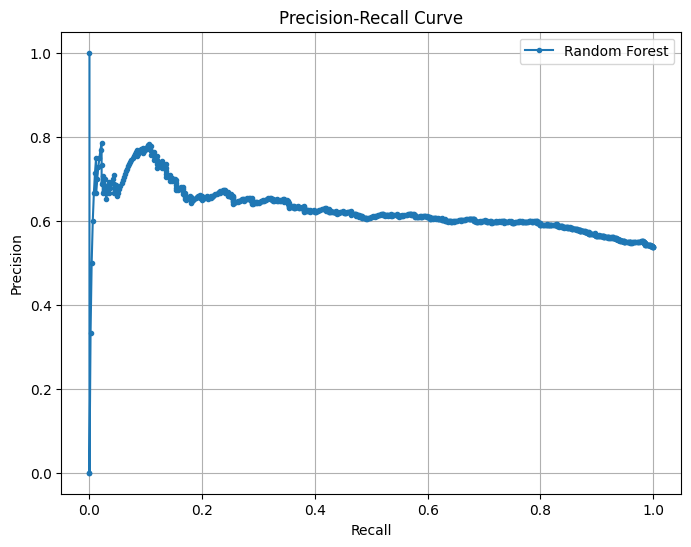

Best Threshold (Max F1): 0.7013
Precision at Best Threshold: 0.0000
Recall at Best Threshold: 0.0000
F1 at Best Threshold: nan

Metrics by Device Type:
     Device    PR-AUC  Precision  Recall   F1
0   Mobile  0.628255        0.0     0.0  0.0
1  Desktop  0.620509        0.0     0.0  0.0
2   Tablet  0.704559        0.0     0.0  0.0

Top 3 Cities:
       City    PR-AUC  Precision  Recall   F1
4  Kayseri  0.744214        0.0     0.0  0.0
8    Adana  0.734067        0.0     0.0  0.0
6  Antalya  0.713319        0.0     0.0  0.0

Bottom 3 Cities:
         City    PR-AUC  Precision  Recall   F1
3      Izmir  0.599263        0.0     0.0  0.0
9      Konya  0.572225        0.0     0.0  0.0
5  Gaziantep  0.470088        0.0     0.0  0.0

Top 10 Feature Importances:
Monetary: 0.1028
Avg_Spend: 0.0902
Recency: 0.0857
Frequency: 0.0842
Avg_Discount: 0.0747
Avg_Session_Duration: 0.0744
Avg_Delivery_Time: 0.0727
Avg_Pages_Viewed: 0.0671
Age: 0.0642
Avg_Rating: 0.0535


/tmp/ipython-input-1388104861.py:21: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

In [5]:
# Get best model
best_model = rf_grid.best_estimator_

# Predict probabilities on Test set
y_probs = best_model.predict_proba(X_test)[:, 1]

# Precision-Recall Curve data
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal threshold (Max F1)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
print(f"Best Threshold (Max F1): {best_threshold:.4f}")
print(f"Precision at Best Threshold: {precision[best_f1_idx]:.4f}")
print(f"Recall at Best Threshold: {recall[best_f1_idx]:.4f}")
print(f"F1 at Best Threshold: {f1_scores[best_f1_idx]:.4f}")

# Let's verify with a business-logic threshold if needed (e.g. 0.45)
# Using the calculated best_threshold for now.

# --- Subgroup Analysis ---

# Recover original features for the test set
test_indices = X_test.index
test_df = customer_features.loc[test_indices].copy()
test_df['churn_prob'] = y_probs
test_df['churn_pred'] = (y_probs >= best_threshold).astype(int)
test_df['true_label'] = y_test

def calculate_metrics(df_sub):
    if len(df_sub) == 0:
        return [0,0,0,0]
    y_true = df_sub['true_label']
    y_pred = df_sub['churn_pred']
    y_prob = df_sub['churn_prob']

    # Handle case with only one class
    if len(y_true.unique()) < 2:
        p, r, f1 = precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred, zero_division=0), f1_score(y_true, y_pred, zero_division=0)
        auc = 0 # Undefined
    else:
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = average_precision_score(y_true, y_prob)

    return [auc, p, r, f1]

# 1. By Device Type
device_metrics = []
for device in test_df['Fav_Device'].unique():
    sub_df = test_df[test_df['Fav_Device'] == device]
    metrics = calculate_metrics(sub_df)
    device_metrics.append([device] + metrics)

device_results = pd.DataFrame(device_metrics, columns=['Device', 'PR-AUC', 'Precision', 'Recall', 'F1'])
print("\nMetrics by Device Type:\n", device_results)

# 2. By City
city_metrics = []
for city in test_df['City'].unique():
    sub_df = test_df[test_df['City'] == city]
    metrics = calculate_metrics(sub_df)
    city_metrics.append([city] + metrics)

city_results = pd.DataFrame(city_metrics, columns=['City', 'PR-AUC', 'Precision', 'Recall', 'F1'])
city_results = city_results.sort_values('PR-AUC', ascending=False)

print("\nTop 3 Cities:\n", city_results.head(3))
print("\nBottom 3 Cities:\n", city_results.tail(3))

# Feature Importance Check (to ensure it's not random)
feature_names = numeric_features + list(best_model.named_steps['preprocessor'].transformers_[1][1]['encoder'].get_feature_names_out(categorical_features))
importances = best_model.named_steps['classifier'].feature_importances_

# Sort and print top 10
indices = np.argsort(importances)[::-1]
print("\nTop 10 Feature Importances:")
for i in range(10):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

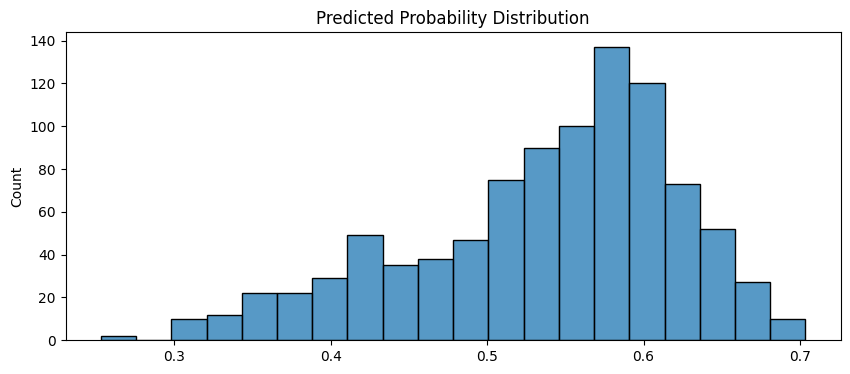

Refined Best Threshold (Max F1): 0.3617
Metrics at this threshold: P=0.5512, R=0.9824, F1=0.7061
Threshold for ~80% Recall: 0.4973
Metrics: P=0.5887, R=0.8000
Selected Final Threshold: 0.3617

Metrics by Device Type:
     Device    PR-AUC  Precision    Recall        F1
0   Mobile  0.628255   0.556213  0.982578  0.710327
1  Desktop  0.620509   0.541899  0.979798  0.697842
2   Tablet  0.704559   0.568182  1.000000  0.724638

Top 3 Cities:
       City    PR-AUC  Precision    Recall        F1
4  Kayseri  0.744214   0.555556  1.000000  0.714286
8    Adana  0.734067   0.671642  0.978261  0.796460
6  Antalya  0.713319   0.578947  1.000000  0.733333

Bottom 3 Cities:
         City    PR-AUC  Precision    Recall        F1
3      Izmir  0.599263   0.504505  0.965517  0.662722
9      Konya  0.572225   0.500000  0.966667  0.659091
5  Gaziantep  0.470088   0.423077  1.000000  0.594595


In [6]:
# 1. Analyze Probability Distribution
plt.figure(figsize=(10, 4))
sns.histplot(y_probs, bins=20)
plt.title('Predicted Probability Distribution')
plt.show()

# 2. Pick threshold where F1 is maximized (ignoring NaNs/Zeros correctly)
# Calculate F1 for all thresholds
valid_f1 = np.nan_to_num(f1_scores)
best_f1_idx = np.argmax(valid_f1)
best_threshold_f1 = thresholds[best_f1_idx]
print(f"Refined Best Threshold (Max F1): {best_threshold_f1:.4f}")
print(f"Metrics at this threshold: P={precision[best_f1_idx]:.4f}, R={recall[best_f1_idx]:.4f}, F1={valid_f1[best_f1_idx]:.4f}")

# 3. Alternative: Threshold for Recall ~ 0.8
recall_target = 0.8
idx_recall = np.argmin(np.abs(recall - recall_target))
threshold_recall = thresholds[idx_recall]
print(f"Threshold for ~80% Recall: {threshold_recall:.4f}")
print(f"Metrics: P={precision[idx_recall]:.4f}, R={recall[idx_recall]:.4f}")

# Select a threshold for final reporting.
# Let's go with the Max F1 threshold if it's not 0 or 1, otherwise the Recall-based one.
if valid_f1[best_f1_idx] > 0:
    final_threshold = best_threshold_f1
else:
    final_threshold = threshold_recall

print(f"Selected Final Threshold: {final_threshold:.4f}")

# --- Re-run Subgroup Analysis with Final Threshold ---
test_df['churn_pred'] = (y_probs >= final_threshold).astype(int)

# 1. By Device Type
device_metrics = []
for device in test_df['Fav_Device'].unique():
    sub_df = test_df[test_df['Fav_Device'] == device]
    metrics = calculate_metrics(sub_df)
    device_metrics.append([device] + metrics)

device_results = pd.DataFrame(device_metrics, columns=['Device', 'PR-AUC', 'Precision', 'Recall', 'F1'])
print("\nMetrics by Device Type:\n", device_results)

# 2. By City
city_metrics = []
for city in test_df['City'].unique():
    sub_df = test_df[test_df['City'] == city]
    metrics = calculate_metrics(sub_df)
    city_metrics.append([city] + metrics)

city_results = pd.DataFrame(city_metrics, columns=['City', 'PR-AUC', 'Precision', 'Recall', 'F1'])
city_results = city_results.sort_values('PR-AUC', ascending=False)

print("\nTop 3 Cities:\n", city_results.head(3))
print("\nBottom 3 Cities:\n", city_results.tail(3))